In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

%matplotlib inline


# Joint Inference of Population and Cosmology: Selection function

The following expressions are essentially same as those in [Farr, 2019](https://arxiv.org/pdf/1904.10879.pdf) and [Essick and Farr, 2022](https://arxiv.org/pdf/2204.00461.pdf) applied in the context of cosmopop. The standard hierarchical posterior for parametric models, marginalized over the astrophysical rate of events R,
$$
p(\vec{\Omega}|\vec{d})\propto p(\vec{\Omega})\int dR p(R) e^{R\beta_{det}(\vec{\Omega})}\prod_i R \int p(d_i|\vec{\theta})p(\vec{\theta}|\vec{\Omega})\quad \quad \quad \quad ...(i)
$$

where,

$$
\beta_{det}(\vec{\Omega})= \int_{\{d:\rho(d)>\rho_{th}\}} d\vec{d} \int d\vec{\theta}p(d|\vec{\theta})p(\vec{\theta}|\vec{\Omega}) = \int P(\rho(d)>\rho_{th}|\vec{\theta})p(\vec{\theta}|\vec{\Omega}) \quad \quad \quad \quad ...(ii)
$$
Is the fraction of detectable events at a given (thin)slice of the hyper-parameter space. Before we procced to compute it, let us first marginalize out the astrophysical rate analytically, using a $\frac{1}{R}$ prior on the Rates, (as in [Farr, 2019](https://arxiv.org/pdf/1904.10879.pdf)):

$$
p(\vec{\Omega}|\vec{d})\propto p(\vec{\Omega})\frac{1}{\beta_{det}^{N}(\vec{\Omega})}\prod_i^N \int p(d_i|\vec{\theta})p(\vec{\theta}|\vec{\Omega}) \quad \quad \quad \quad ...(iii)
$$

## Computing $\beta_{det}$

Lets use the short hand "det" for $\rho(d)>\rho_{th}$. To eveluate the integral in (ii) as a Monte Carlo sum over detectable injections whose parameters are drawn from some fiducial distributions, we use Bayes theorem (following [Essick and Farr, 2022](https://arxiv.org/pdf/2204.00461.pdf) ) to write: 

$$
P(det|\vec{\theta})p(\vec{\theta}|draw) = p(\vec{\theta}|det,draw)P(det|draw)
$$

The parameters of the injections that satisfy our SNR cut can be interpreted as i.i.d. draws from $p(\vec{\theta}|det,draw)$ hence allowing us to compute $\beta_{det}$ emperically:



$$
\hat{\beta}_{deta} \approx \times\frac{1}{N_{draw}}\sum_{i:\vec{\theta}_i\sim p(\vec{\theta}|det,draw)}^{n_{det}}\frac{p(\vec{\theta}_i|\vec{\Omega})}{p(\vec{\theta}_i|draw)}\quad \quad ...(iiia)
$$

where we have approximated $P(det|draw) \approx \frac{n_{det}}{N}$ . Note that the $\hat{~}$ in eqn(iiia) represents the fact that the right hand side is an estimator of the true $\beta_{det}$. We will varify that the estimator is accurate enough by investigating the uncertainties of the estimator in the later parts of the notebook

<!-- In the context of Cosmo+pop,

$$
p(\vec{\theta}|\vec{\Omega}) = p(\mathcal{M}_z,q,d_L|\vec{\Omega}_{cos},\vec{\Omega}_{pop}) = \int p(\mathcal{M}_z|\mathcal{M},z)p(\mathcal{M},q|\vec{\Omega}_{pop})p(z|d_L,\vec{\Omega}_{cos})p(d_L|\vec{\Omega}_{cos})d\mathcal{M}dz  \quad \quad \quad \quad ...(iv)
$$

where $p(\mathcal{M},q|\vec{\Omega}_{pop})$ is our population model for the source frame masses parameterized by population hyper-parameters $\vec{\Omega}_{pop}$ and $p(\mathcal{M}_z|\mathcal{M},z),p(z|d_L,\vec{\Omega}_{cos})$ are deterministic priors imposed by cosmological effects ,parameterized by the cosmological hyper parameters $\vec{\Omega}_{cos}$.

For the marginalization integral in (iii), we can use bayes theorem to re-write the likelihood in terms of the posterior: $p(\vec{\theta}|d_i)\propto p(\vec{d}_i|\vec{\theta})p_{PE}(\vec{\theta})$, which has already been sampled during single event PE runs that were carried out with priors $p_{PE}(\vec{\theta})$ agnostic to the hierarchical model being inferred. This allows us to approximate the marginalization integrals as Monte Carlo sums over posterior samples re-weighted by the prior used during single event model-agnostic PE. With the further approximation of the ith event posterior as a delta function in the detector frame chirp mass, centered about the mean of the PE samples $\bar{\mathcal{M}}_{z,i}$, Our final expression looks like: 

$$
p(\vec{\Omega}_{pop},\vec{\Omega}_{cos}|\vec{d}) \propto \frac{\prod_{i}^{N_{events}}\sum_{j:(q_j,d_{L,j})\sim p(q,d_L|d_i) }\frac{p(\frac{\bar{\mathcal{M}}_{z,i}}{1+Z_D(d_{L,j},\vec{\Omega}_{cos})},q_j|\vec{\Omega}_{pop})}{p_{PE}(q_j,d_{L,j})}\times \frac{1}{1+Z_D(d_{L,j},\vec{\Omega}_{cos})}}{\{\sum_{k:(\mathcal{M}_{z,k},q_k,d_{L,k})\sim p(\mathcal{M}_z,q,d_L|det,draw)}\frac{p(\frac{\mathcal{M}_{z,k}}{1+Z_D(d_{L,k},\vec{\Omega}_{cos})},q_k|\vec{\Omega}_{pop})}{p(\mathcal{M}_{z,k},q_k,d_{L,k}|draw)}\times \frac{p(d_{L,k}|\vec{\Omega}_{cos})}{1+Z_D(d_{L,k},\vec{\Omega}_{cos})}\}^{N_{events}}}\quad ...(v)
$$

where $Z_{D}(d_{L},\vec{\Omega}_{cos})$ is the inverse luminosity distance function for a cosmological model parameterized by $\vec{\Omega}_{cos})$ -->

# Viualization of $p(\vec{\theta}|det,draw)$

Waveform parameters are drawn from a fiducial distribution are used to calculate a waveform which is injected into noise realizations corresponding to O4 sensitivity. The optimal SNR is calculated and saved. This is parallelized on Condor to produce a large number (50 million injections)

### Load files

In [1]:
fnames = glob.glob('out/*.txt')
DL, MCZ,Q,RHO_L,RHO_H,RHO_V,RHO_K= np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for fn in fnames:
    dl,Mcz,q,rho_l,rho_h,rho_v,rho_k= np.loadtxt(fn,skiprows=1,usecols=[3,4,5,10,11,12,13],unpack=True)
    DL=np.append(DL,dl)
    MCZ=np.append(MCZ,Mcz)
    Q=np.append(Q,q)
    RHO_L=np.append(RHO_L,rho_l)
    RHO_H=np.append(RHO_H,rho_h)
    RHO_K=np.append(RHO_K,rho_k)
    RHO_V=np.append(RHO_V,rho_v)

### SNR distribution

In [16]:
rho_net = np.sqrt(RHO_L**2+RHO_H**2+RHO_V**2+ RHO_K**2)

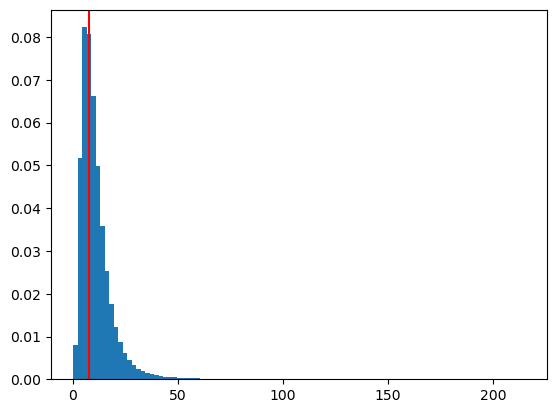

In [17]:
A = plt.hist(rho_net,bins=100,density = True)
plt.axvline(8.0,color='r')

## $p(\vec{\theta}|det,draw)$ vs $p(\vec{\theta}|draw)$

In [18]:
draw = np.array([MCZ,Q,DL]).T[0::100]

In [19]:

rho_th = 8.
selector = np.where((rho_net[0::100]>=rho_th)+(RHO_L[0::100]>=rho_th)+(RHO_H[0::100]>=rho_th)+(RHO_V[0::100]>=rho_th)+(RHO_K[0::100]>=rho_th))[0]
det_draw = draw[selector]

In [4]:
MCZ,Q,DL,RHO_L,RHO_H,RHO_V,RHO_K = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

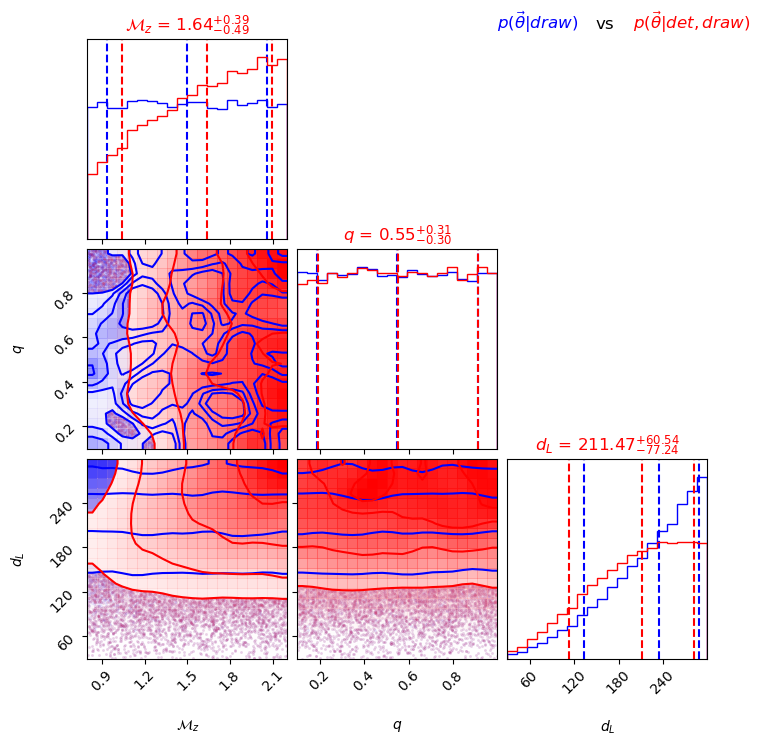

In [21]:
import corner

fig = corner.corner(draw,labels=[r'$\mathcal{M}_z$',r'$q$',r'$d_L$'],smooth=1.2,quantiles=[0.1,0.5,0.9],color='b',show_titles=True,title_kwargs={"fontsize": 12,"color":'b'},use_math_text=True,hist_kwargs={"density":True})
fig = corner.corner(det_draw,labels=[r'$\mathcal{M}_z$',r'$q$',r'$d_L$'],smooth=1.2,quantiles=[0.1,0.5,0.9],color='r',show_titles=True,title_kwargs={"fontsize": 12,"color":'r'},use_math_text=True,hist_kwargs={"density":True},fig=fig)
plt.figtext(0.67, 0.96, r"$p(\vec{\theta}|draw)$", fontsize='large', color='b', ha ='left')
plt.figtext(0.80, 0.96, "vs", fontsize='large', ha ='left')
plt.figtext(0.85, 0.96, r"$p(\vec{\theta}|det,draw)$", fontsize='large', color='r', ha ='left')
plt.show()


# Re-weighting the red to the blur


In [22]:
import bilby
from astropy.cosmology import Planck18
def p_draw(d_L):
    return bilby.gw.prior.UniformSourceFrame(30.,300.,cosmology=Planck18,name='luminosity_distance').prob(d_L)
pdraw = p_draw(draw[:,2][selector])

In [23]:
np.savetxt('det_draw.txt',np.c_[det_draw[:,0],det_draw[:,1],det_draw[:,2],pdraw])

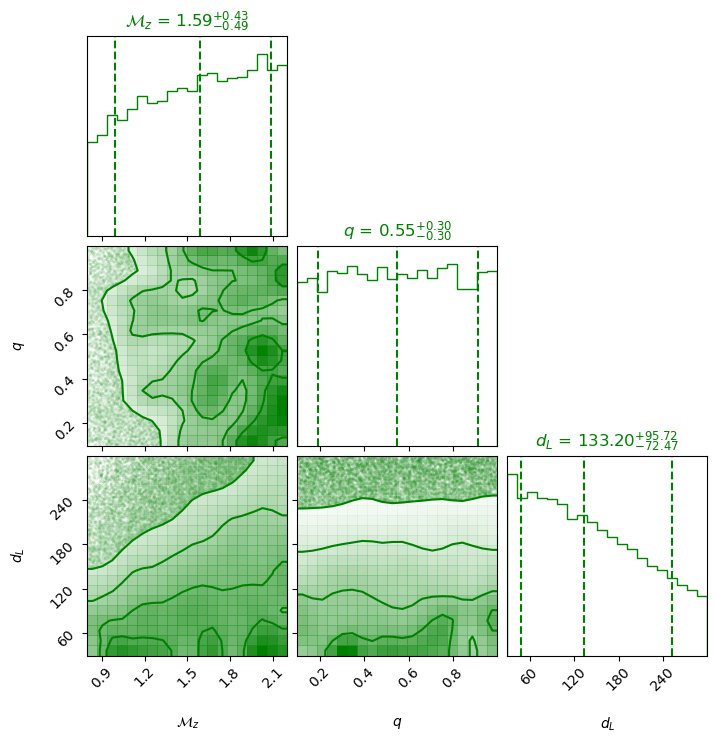

In [24]:
fig = corner.corner(det_draw,labels=[r'$\mathcal{M}_z$',r'$q$',r'$d_L$'],weights = 1./pdraw,smooth=1.2,quantiles=[0.1,0.5,0.9],color='g',show_titles=True,title_kwargs={"fontsize": 12,"color":'g'},use_math_text=True,hist_kwargs={"density":True})
plt.show()

# Population priors in $\mathcal{M},q$ from that in $m_1,m_2$

$$
p_{\mathcal{M},q}(\mathcal{M},q|\vec{\Omega}_p)=\int p(\mathcal{M},q|m_1,m_2)p_{m_1,m_2}(m_1,m_2|\vec{\Omega}_p)dm_1dm_2
$$
where,  
$$
p(\mathcal{M},q|m_1,m_2) = \delta(\mathcal{M}-\frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}})\times\{\delta(q-\frac{m_2}{m_1})\Theta(m_1-m_2)+\delta(q-\frac{m_1}{m_2})\Theta(m_2-m_1)\}
$$
The symmetrization in the above expression implies:
$$
\int p(\mathcal{M},q|m_1,m_2)p(m_1,m_2|\vec{\Omega}_p)dm_1dm_2 = \int \delta(\mathcal{M}-\frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}})\delta(q-\frac{m_2}{m_1})\Theta(m_1-m_2)\times\{p_{m_1,m_2}(m_1,m_2|\vec{\Omega}_p)+p_{m_1,m_2}(m_2,m_1|\vec{\Omega}_p)\}dm_1dm_2
$$

Now if we re-write the delta functions using the Jacobians:

$$
\delta(\mathcal{M}-\frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}})\delta(q-\frac{m_2}{m_1})=\delta(m_1 - q^{-3/5}(1+q)^{1/5}\mathcal{M})\delta(m_2 - q^{2/5}(1+q)^{1/5}\mathcal{M})q^{-6/5}(1+q)^{2/5}\mathcal{M}
$$

substituting and integrating,

$$
p_{\mathcal{M},q}(\mathcal{M},q|\vec{\Omega}_p)=\{p_{m_1,m_2}(q^{-3/5}(1+q)^{1/5}\mathcal{M},q^{2/5}(1+q)^{1/5}\mathcal{M}|\vec{\Omega}_p)+p_{m_1,m_2}(q^{2/5}(1+q)^{1/5}\mathcal{M},q^{-3/5}(1+q)^{1/5}\mathcal{M}|\vec{\Omega}_p)\}q^{-6/5}(1+q)^{2/5}\mathcal{M}\Theta(1-q)\quad\quad ...(vi)
$$

Note that these distributions are normalized in $\mathcal{M},q$ by construction

### for populations symmetric in $m_1,m_2$ like  $p_{m_1,m_2}(m_1,m_2|\vec{\Omega}_P)=p_m(m_1|\vec{\Omega}_p)p_m(m_2|\vec{\Omega}_p)$

We get:
$$
p_{\mathcal{M},q}(\mathcal{M},q|\vec{\Omega}_p)=2p_{m}(q^{-3/5}(1+q)^{1/5}\mathcal{M})p_{m}(q^{2/5}(1+q)^{1/5}\mathcal{M}|\vec{\Omega}_p)q^{-6/5}(1+q)^{2/5}\mathcal{M}\Theta(1-q)\quad \quad ...(vii)
$$


In [4]:
# Cosmo support functions
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

## $\beta_{det}$

In [26]:
pdraw = at.as_tensor(pdraw)

# With q

In [27]:
print(det_draw.shape)

(29408, 3)


In [15]:
det_draw = np.loadtxt('det_draw.txt',usecols=[0,1,2])
p_draw= at.as_tensor(np.loadtxt('det_draw.txt',usecols=[3]))
[Mcz,q,d_L] = det_draw.T



Mcz_det = at.as_tensor(Mcz)
d_L_det= at.as_tensor(d_L)
q_det = at.as_tensor(q)

zmax = 10

zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), 1024))
N_tot = len(Mcz)


N_events = 62
tune = 1000
target_accept = 0.99
wDM = 0
with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 1., 2.5) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.01, 0.25)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792*(10**3) / h) # Mpc
        
        ds_det = d_L_det
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z_det = at_interp(ds_det, dLinterp, zinterp)
        z_unit_det = z_det/10
        
        var_det = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit_det))
        
        ddLdz_det = ds_det/(1+z_det)+dH*(1+z_det)/Ez(z_det, Om, w, wDM)
        var1_det = 1./(10*ddLdz_det)
        
        var2_det = 1/(1+z_det)
        
        Mc_det = Mcz_det/(1 + z_det)
        
        m1_det = q_det**(-0.6)*(1+q_det)**0.2*Mc_det
        m2_det = q_det**0.4*(1+q_det)**0.2*Mc_det
        var3_det = q_det**(-1.2)*(1+q_det)**0.4*Mc_det
        var4_det = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), m1_det))
        var5_det = at.exp(pm.logp(pm.Normal.dist(mu_P,sigma_P),m2_det))
        
        
        var6_det = at.sum(var_det*var1_det*var2_det*var3_det*var4_det*var5_det/pdraw)/N_tot
        pm.Potential('det', at.log(var6_det)*N_events)
        #pm.Potential('pos', at.sum(at.log(var6))-at.log(var6_det)-N_events)
        trace = pm.sample(tune=tune, target_accept=target_accept)
        

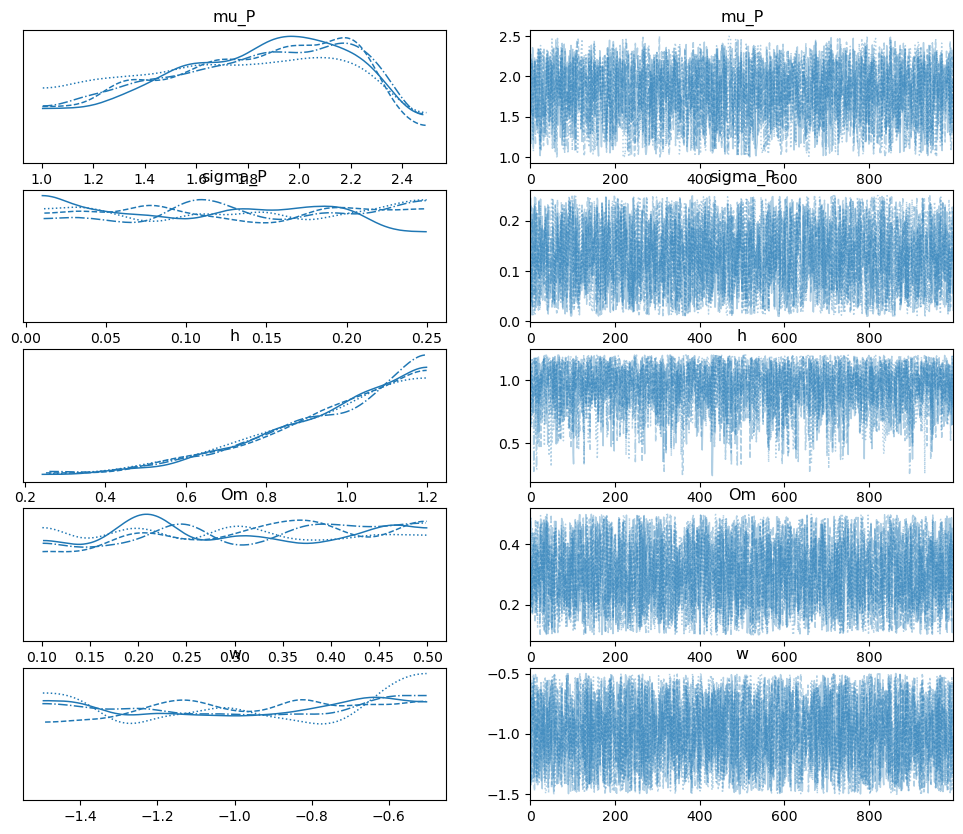

In [16]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'])
    fig = axes.ravel()[0].figure
    fig.savefig('O4_sel_with_q.png')

# With $\mathcal{M}_z,M_z,d_L$

$$
\beta_{det}(\vec{\Omega_p},\vec{\Omega_c})=\int P(det|\mathcal{M}_z,M_z,d_L)p(\mathcal{M}_z,M_z,d_L|\vec{\Omega_p},\vec{\Omega_c})d\mathcal{M}_zdM_zdd_L
$$

$$
\implies \beta_{det}(\vec{\Omega_p},\vec{\Omega_c})=\int P(det|\mathcal{M}_z,q,d_L)p(q|\mathcal{M}_z,M_z)p(\mathcal{M}_z,M_z,d_L|\vec{\Omega_p},\vec{\Omega_c})d\mathcal{M}_zdM_zdd_Ldq
$$
where 
$$
p(q|\mathcal{M}_z,M_z)=\delta(q-f_q(M_z,\mathcal{M}_z))=\delta (M_z-f_{M_z}(q,\mathcal{M}_z)|\frac{dM_z}{dq}((q,\mathcal{M}_z))|
$$

$$
\implies p(q|\mathcal{M}_z,M_z)= \delta(M_z-\mathcal{M}_zq^{-3/5}(1+q)^{6/5})\times\mathcal{M}_z\times|-\frac{3}{5}q^{-8/5}(1+q)^{6/5}+\frac{6}{5}q^{-3/5}(1+q)^{1/5}|
$$
Substituting and integrating over $M_z$,
$$
\beta_{det}(\vec{\Omega_p},\vec{\Omega_c})=\int P(det|\mathcal{M}_z,q,d_L)p(\mathcal{M}_z,M_z=\mathcal{M}_zq^{-3/5}(1+q)^{6/5},d_L|\vec{\Omega_p},\vec{\Omega_c})\mathcal{M}_z\times|-\frac{3}{5}q^{-8/5}(1+q)^{6/5}+\frac{6}{5}q^{-3/5}(1+q)^{1/5}|d\mathcal{M}_zdd_Ldq
$$

$$
\implies \beta_{det}(\vec{\Omega_p},\vec{\Omega_c})=P(det|draw)\int \frac{p(\mathcal{M}_z,q,d_L|det,draw)}{p(\mathcal{M}_z,q,d_L|draw)}p(\mathcal{M}_z,M_z=\mathcal{M}_zq^{-3/5}(1+q)^{6/5},d_L|\vec{\Omega_p},\vec{\Omega_c})\mathcal{M}_z\times|-\frac{3}{5}q^{-8/5}(1+q)^{6/5}+\frac{6}{5}q^{-3/5}(1+q)^{1/5}|d\mathcal{M}_zdd_Ldq
$$
Approximate as sum over detectable samples:
$$
\implies \beta_{det}(\vec{\Omega_p},\vec{\Omega_c})=\frac{1}{N_{draw}}\sum_{k:(\mathcal{M}_{z,k},q_k,d_{L,k})\sim p(\mathcal{M}_z,q,d_L|det,draw)}\frac{p(\mathcal{M}_{z,k},M_z=\mathcal{M}_{z,k}q_k^{-3/5}(1+q_k)^{6/5},d_{L,k}|\vec{\Omega_p},\vec{\Omega_c})}{{p(\mathcal{M}_{z,k},q_k,d_{L,k}|draw)}}\mathcal{M}_{z,k}\times|-\frac{3}{5}q_k^{-8/5}(1+q_k)^{6/5}+\frac{6}{5}q_k^{-3/5}(1+q_k)^{1/5}|
$$
where our population prior is:
$$
p(\mathcal{M}_{z,k},M_z=\mathcal{M}_{z,k}q_k^{-3/5}(1+q_k)^{6/5},d_{L,k}|\vec{\Omega_p},\vec{\Omega_c})=\mathcal{N}_{\frac{\mathcal{M}_{z,k}}{1+Z_D(d_{L,k})}}((0.25)^{3/5}\mu_P,(0.25)^{3/5}\sigma_P)\mathcal{N}_{\frac{\mathcal{M}_{z,k}}{1+Z_D(d_{L,k})}q_k^{-3/5}(1+q_k)^{6/5}}(\mu_P,\sigma_P) \times p(d_{L,k}|\vec{\Omega}_c) \times\frac{1}{(1+Z_D(d_L,\vec{\Omega}_c))^2}
$$

In [ ]:
det_draw = np.loadtxt('det_draw.txt',usecols=[0,1,2])
p_draw= at.as_tensor(np.loadtxt('det_draw.txt',usecols=[3]))
[Mcz,q,d_L] = det_draw.T



Mcz_det = at.as_tensor(Mcz)
d_L_det= at.as_tensor(d_L)
q_det = at.as_tensor(q)

zmax = 10

zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), 1024))
N_tot = len(Mcz)


N_events = 62
tune = 1000
target_accept = 0.99
wDM = 0
with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 2.*1., 2.*2.5) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', np.sqrt(2)*0.01, np.sqrt(2)*0.25)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792*(10**3) / h) # Mpc
        
        ds_det = d_L_det
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z_det = at_interp(ds_det, dLinterp, zinterp)
        z_unit_det = z_det/10
        
        var_det = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit_det))
        
        ddLdz_det = ds_det/(1+z_det)+dH*(1+z_det)/Ez(z_det, Om, w, wDM)
        var1_det = 1./(10*ddLdz_det)
        
        var2_det = 1/(1+z_det)**2
        
        Mc_det = Mcz_det/(1 + z_det)
        
        M_det = q_det**(-0.6)*(1+q_det)**1.2*Mc_det
        var3_det = abs((-3/5.)*q_det**(-8./5.)*(1+q_det)**1.2+(6./5.)*q_det**(-3./5.)*(1+q_det)**(1./5.))*Mcz_det
        var4_det = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), M_det))
        var5_det = at.exp(pm.logp(pm.Normal.dist(mu_P*(0.25)**(3./5.),sigma_P*(0.25)**(3./5.)),Mc_det))
        
        
        var6_det = at.sum(var_det*var1_det*var2_det*var3_det*var4_det*var5_det/p_draw)/N_tot
        pm.Potential('det', N_events*at.log(var6_det))
        #pm.Potential('pos', at.sum(at.log(var6))-at.log(var6_det)*N_events)
        trace = pm.sample(tune=tune, target_accept=target_accept,cores=8)#,chains = 8,cores=8)
        

In [ ]:
# with model:
#     axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'])
#     fig = axes.ravel()[0].figure
#     fig.savefig('O4_sel_with_Mtot.png')

# Precision requirements for Monte Carlo estimates
As mentioned before, the  $\hat{\beta}_{det}$ in eqn (iiia) is actually an estimator of the true selection function $\beta_{det}$. To check whether the estimator is accurate enough, we will calculate the mean and variance of the estimator.

## Single realization, Following [Essick and Farr, 2022](https://arxiv.org/pdf/2204.00461.pdf)

If we have a single set of injections for estimating $\beta_{det}$, we can estimate the mean and variance of the estimator by modelling the uncertainties of the estimator and marginalize over them. Following [Essick and Farr, 2022](https://arxiv.org/pdf/2204.00461.pdf), we model the uncertainties in $\hat{\beta}_{det}$ as a lognormal distribution:
